# Comparing Vanilla and KeOps-Based Multi-Head Attention

Attention mechanisms have revolutionized deep learning in recent years by allowing models to focus on different parts of the input. In this tutorial, we compare two implementations of multi-head self-attention: a conventional (vanilla) version using standard PyTorch and an optimized version based on **KeOps**.

## What is attention

The **attention mechanism** allows a model to assign varying levels of importance to different input elements. It was first popularized in machine translation and has since become central to many domains.
$$
\text{Attention}(Q, K, V) = \text{softmax} \left( \frac{QK^\top}{\sqrt{d_k}} \right) V
$$
where:
- $Q$ (queries), $K$ (keys), and $V$ (values) are matrices derived from the input.
- $d_k$ is the dimensionality of the queries and keys.
- The scaling by $\sqrt{d_k}$ helps stabilize gradients by preventing overly large dot products.

## Self-attention

**Self-attention** is a variant where the queries, keys, and values all come from the same source. In a sequence (e.g., a sentence), each token is allowed to “attend” to every other token. This flexibility is a key strength of Transformer architectures.

## Multi-head attention
Instead of performing one single attention operation, multi-head attention splits the model’s representation into several “heads.” Each head independently computes attention:

**Advantages:**
- Allows the model to capture different types of relationships.
- Improves representation capacity by providing multiple subspaces for learning similarities.

The outputs of these heads are then concatenated and projected to form the final output.

## KeOps in attention
KeOps is designed for efficient computation of large-scale kernel operations, particularly when memory becomes a bottleneck. By using a specialized reduction operator, the KeOps-based attention can perform the softmax-weighted sum more efficiently, especially for long sequences.

## Implementation details
We implemented two variants of multi-head attention:

### Vanilla Multi-head attention
The vanilla implementation follows the standard procedure:

**Input Projection:**
The input tensor $X$ of shape $(\text{batch\_size}, \text{seq\_len}, d_{\text{model}})$ is projected into queries, keys, and values using separate linear layers.

**Head Splitting:**
The projections are reshaped into $(\text{batch\_size}$, $\text{num\_heads}$, $\text{seq\_len}$, $d_k)$ by splitting the model dimension.

**Scaled Dot-Product Attention:**
For each head, compute the dot products between queries and transposed keys, scale by $\sqrt{d_k}$, and apply softmax.

**Weighted Sum:**
Multiply the softmax scores by the values to obtain each head’s output.

**Concatenation and Projection:**
Concatenate the heads back to shape $(\text{batch\_size}, \text{seq\_len}, d_{\text{model}})$ and apply a final linear layer.

In [1]:
!python3 -c "import pykeops; pykeops.clean_pykeops();"

[KeOps] /home/nizarben/.cache/keops2.2.3/Linux_ankhhaf_5.15.0-131-generic_p3.12.2 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from pykeops.torch import Genred

import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
class VanillaMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads  # Dimension per head

        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Project input to Q, K, V
        Q = self.W_q(x)  # (batch_size, seq_len, d_model)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape and transpose for multi-head: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Compute attention scores: (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)

        # Apply softmax to get attention weights
        weights = F.softmax(scores, dim=-1)

        # Compute weighted sum: (batch_size, num_heads, seq_len, d_k)
        output = torch.matmul(weights, V)

        # Reshape back: (batch_size, seq_len, d_model)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Final linear projection
        output = self.W_o(output)
        return output

In [4]:
class KeOpsMultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections (same as vanilla)
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        # Define KeOps reduction with self.reduction
        formula = '((Q|K)/D)'
        aliases = [
            f'Q = Vi({self.d_k})',  # Query vectors, i-dimension (seq_len)
            f'K = Vj({self.d_k})',  # Key vectors, j-dimension (seq_len)
            f'V = Vj({self.d_k})',  # Value vectors, j-dimension (seq_len)
            'D = Pm(1)',           # Scaling factor (scalar)
        ]
        formula2 = 'V'
        reduction_op = 'SumSoftMaxWeight'
        self.reduction = Genred(formula, aliases, reduction_op=reduction_op, formula2=formula2, axis=1)

    def forward(self, x):
        batch_size, seq_len, d_model = x.shape

        # Project input to Q, K, V
        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        # Reshape for multi-head: (batch_size, num_heads, seq_len, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Flatten batch and heads: (batch_size * num_heads, seq_len, d_k)
        Q_flat = Q.reshape(batch_size * self.num_heads, seq_len, self.d_k)
        K_flat = K.reshape(batch_size * self.num_heads, seq_len, self.d_k)
        V_flat = V.reshape(batch_size * self.num_heads, seq_len, self.d_k)

        # Define scaling factor D = sqrt(d_k)
        D = torch.tensor([np.sqrt(self.d_k)], dtype=x.dtype, device=x.device)

        # Apply KeOps reduction: (batch_size * num_heads, seq_len, d_k)
        output_flat = self.reduction(Q_flat, K_flat, V_flat, D)

        # Reshape back: (batch_size, seq_len, d_model)
        output = output_flat.view(batch_size, self.num_heads, seq_len, self.d_k)
        output = output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Final linear projection
        output = self.W_o(output)
        return output

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FlashMultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention using PyTorch's scaled_dot_product_attention
    which can leverage Flash Attention kernels internally.
    """
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        # Linear projections for Q, K, V, and output
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x):
        """
        x shape: (batch_size, seq_len, d_model)
        returns: (batch_size, seq_len, d_model)
        """
        batch_size, seq_len, _ = x.shape

        # Project input to Q, K, V
        Q = self.W_q(x)  # (B, L, d_model)
        K = self.W_k(x)  # (B, L, d_model)
        V = self.W_v(x)  # (B, L, d_model)

        # Reshape to (B, num_heads, L, d_k)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

        # Use PyTorch's scaled_dot_product_attention.
        # This will dispatch to fast kernels (including "Flash Attention") 
        # when possible (e.g., dropout=0, certain dtypes, etc.).
        # Returned shape is (B, num_heads, L, d_k).
        attn_output = F.scaled_dot_product_attention(
            Q, K, V,
            attn_mask=None,       # or a causal / padding mask if needed
            dropout_p=0.0,        # must be 0.0 for flash kernel
            is_causal=False       # set True if you want causal masking
        )

        # Recombine heads and run final linear projection
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)
        out = self.W_o(attn_output)
        return out


In [7]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [8]:
def test_correctness(vanilla_attn, keops_attn, input_shapes, atol=1e-5, rtol=1e-5):
    """
    For each shape in input_shapes:
      - Runs a forward pass through both modules.
      - Checks that the outputs are allclose.
      - Computes a simple scalar loss (sum) and performs backward.
      - Compares the gradients of a representative parameter.
    """
    for shape in input_shapes:
        print(f"\nTesting shape: {shape}")
        # Create input with gradients enabled
        x = torch.randn(*shape, device=device, requires_grad=True)

        # Zero gradients
        vanilla_attn.zero_grad()
        keops_attn.zero_grad()

        # Forward pass
        out_v = vanilla_attn(x)
        out_k = keops_attn(x)

        # Check forward outputs
        if torch.allclose(out_v, out_k, atol=atol, rtol=rtol):
            print("  Forward outputs match.")
        else:
            diff = (out_v - out_k).abs().max().item()
            print(f"  Forward outputs differ! Max difference = {diff:.6f}")

        # Backward pass 
        loss_v = out_v.sum()
        loss_k = out_k.sum()
        loss_v.backward()
        loss_k.backward()

        # Compare gradients for one parameter
        grad_v = vanilla_attn.W_q.weight.grad
        grad_k = keops_attn.W_q.weight.grad

        if torch.allclose(grad_v, grad_k, atol=atol, rtol=rtol):
            print("  Gradients match for W_q.weight.")
        else:
            grad_diff = (grad_v - grad_k).abs().max().item()
            print(f"  Gradients differ for W_q.weight! Max gradient difference = {grad_diff:.6f}")

In [9]:
# Define a list of input shapes to test: (batch_size, seq_len, d_model)
d_model = 64
num_heads = 8
input_shapes = [
    (2, 10, d_model),
    (4, 128, d_model),
    (8, 256, d_model),
    (16, 1024, d_model),
]

# Initialize both models and copy weights to ensure they are identical.
torch.manual_seed(0)
vanilla_attn = VanillaMultiHeadAttention(d_model, num_heads).to(device)
keops_attn = KeOpsMultiHeadAttention(d_model, num_heads).to(device)
flash_attn = FlashMultiHeadAttention(d_model=64, num_heads=8).to(device)
flash_attn.load_state_dict(vanilla_attn.state_dict())

# Run correctness tests
test_correctness(vanilla_attn, flash_attn, input_shapes)


Testing shape: (2, 10, 64)
  Forward outputs match.
  Gradients match for W_q.weight.

Testing shape: (4, 128, 64)
  Forward outputs match.
  Gradients match for W_q.weight.

Testing shape: (8, 256, 64)
  Forward outputs match.
  Gradients match for W_q.weight.

Testing shape: (16, 1024, 64)
  Forward outputs match.
  Gradients differ for W_q.weight! Max gradient difference = 0.000021


In [10]:
def benchmark_time(module, input_generator, num_runs=10, backward=False):
    # Warm-up runs
    for _ in range(10):
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
    times = []
    for _ in range(num_runs):
        x = input_generator()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        start = time.time()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        times.append((time.time() - start) * 1000.0)  # time unit : milliseconds
    return np.mean(times), np.std(times)

In [11]:
def measure_memory_usage(module, input_generator, num_runs=5, backward=False):
    usage = []
    for _ in range(num_runs):
        torch.cuda.reset_peak_memory_stats(device)
        x = input_generator()
        out = module(x)
        if backward:
            out.sum().backward()
        if torch.cuda.is_available():
            torch.cuda.synchronize()
        usage.append(torch.cuda.max_memory_allocated(device))
    # Convert bytes to MB (torch memory functions return values in bytes)
    return np.mean(usage) / (1024**2), np.std(usage) / (1024**2)

In [12]:
seq_lengths = [128, 256, 512, 1024, 2048]

# Lists to hold benchmark results for each sequence length
vanilla_times = []  # forward-pass time in ms for Vanilla
keops_times = []    # forward-pass time in ms for KeOps
flash_times = []

vanilla_memories = []  # GPU memory in MB for Vanilla
keops_memories = []    # GPU memory in MB for KeOps
flash_memories = []

In [13]:
for seq_len in seq_lengths:
    print(f"\nBenchmarking for seq_len = {seq_len}")
    
    # Define an input generator for this sequence length
    def input_generator(seq_len=seq_len, batch_size=32):
        return torch.randn(batch_size, seq_len, d_model, device=device)
    
    # Measure average forward pass time (ms)
    t_v, t_v_std = benchmark_time(vanilla_attn, input_generator, num_runs=10, backward=False)
    t_k, t_k_std = benchmark_time(keops_attn, input_generator, num_runs=10, backward=False)
    t_f, t_f_std = benchmark_time(flash_attn, input_generator, num_runs=10, backward=False)
    
    vanilla_times.append(t_v)
    keops_times.append(t_k)
    flash_times.append(t_f)
    
    # Measure GPU memory usage (in MB)
    m_v, m_v_std = measure_memory_usage(vanilla_attn, input_generator, num_runs=5, backward=False)
    m_k, m_k_std = measure_memory_usage(keops_attn, input_generator, num_runs=5, backward=False)
    m_f, m_f_std = measure_memory_usage(flash_attn, input_generator, num_runs=5, backward=False)
    
    vanilla_memories.append(m_v)
    keops_memories.append(m_k)
    flash_memories.append(m_f)
    
    print(f"  Vanilla: {t_v:.2f} ms, {m_v:.2f} MB")
    print(f"  KeOps:   {t_k:.2f} ms, {m_k:.2f} MB")
    print(f"  Flash:   {t_f:.2f} ms, {m_f:.2f} MB")


Benchmarking for seq_len = 128
[KeOps] Generating code for Max_SumShiftExpWeight_Reduction reduction (with parameters 0) of formula [(a|b)/d,([1,c])] with a=Var(0,8,0), b=Var(1,8,1), c=Var(2,8,1), d=Var(3,1,2) ... OK
  Vanilla: 0.74 ms, 76.17 MB
  KeOps:   0.85 ms, 34.62 MB
  Flash:   0.32 ms, 28.60 MB

Benchmarking for seq_len = 256
  Vanilla: 1.13 ms, 224.37 MB
  KeOps:   0.92 ms, 51.67 MB
  Flash:   0.62 ms, 39.62 MB

Benchmarking for seq_len = 512
  Vanilla: 3.69 ms, 789.57 MB
  KeOps:   1.24 ms, 85.77 MB
  Flash:   1.82 ms, 61.67 MB

Benchmarking for seq_len = 1024
  Vanilla: 13.51 ms, 2995.17 MB
  KeOps:   2.26 ms, 153.97 MB
  Flash:   6.30 ms, 105.77 MB

Benchmarking for seq_len = 2048
  Vanilla: 56.62 ms, 11707.17 MB
  KeOps:   5.23 ms, 290.37 MB
  Flash:   24.21 ms, 193.97 MB


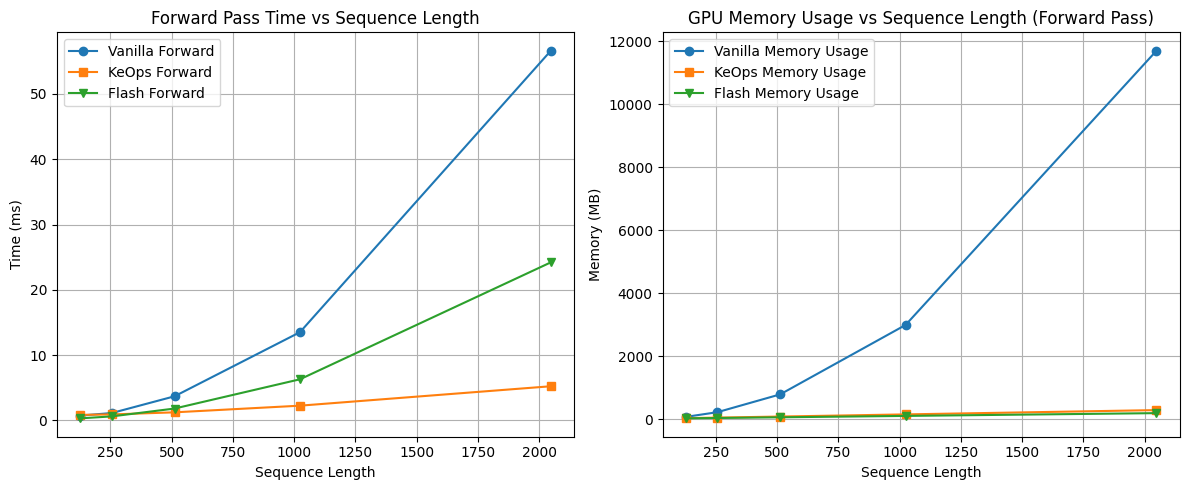

In [15]:
# Plot the timing comparisons (line graphs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(seq_lengths, vanilla_times, marker='o', label="Vanilla Forward")
plt.plot(seq_lengths, keops_times, marker='s', label="KeOps Forward")
plt.plot(seq_lengths, flash_times, marker='v', label="Flash Forward")

plt.xlabel("Sequence Length")
plt.ylabel("Time (ms)")
plt.title("Forward Pass Time vs Sequence Length")
plt.legend()
plt.grid(True)

# Plot the memory consumption comparisons (line graphs in MB)
plt.subplot(1, 2, 2)
plt.plot(seq_lengths, vanilla_memories, marker='o', label="Vanilla Memory Usage")
plt.plot(seq_lengths, keops_memories, marker='s', label="KeOps Memory Usage")
plt.plot(seq_lengths, flash_memories, marker='v', label="Flash Memory Usage")

plt.xlabel("Sequence Length")
plt.ylabel("Memory (MB)")
plt.title("GPU Memory Usage vs Sequence Length (Forward Pass)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [16]:
keops_seq_lengths = [4096, 10000, 20000, 50000]
for seq_len in keops_seq_lengths:
    print(f"\nBenchmarking for seq_len = {seq_len}")
    
    # Define an input generator for this sequence length
    def input_generator(seq_len=seq_len, batch_size=256):
        return torch.randn(batch_size, seq_len, d_model, device=device)
    
    # Attempt to run the benchmark for timing
    try:
        t_k, t_k_std = benchmark_time(keops_attn, input_generator, num_runs=10, backward=False)
        t_f, t_f_std = benchmark_time(flash_attn, input_generator, num_runs=10, backward=False)
    except RuntimeError as e:
        print(f"  Error during timing for seq_len = {seq_len}: {e}")
        t_k, t_k_std = None, None
        t_f, t_f_std = None, None

    # Attempt to run the benchmark for memory usage
    try:
        m_k, m_k_std = measure_memory_usage(keops_attn, input_generator, num_runs=5, backward=False)
        m_f, m_f_std = measure_memory_usage(flash_attn, input_generator, num_runs=5, backward=False)
    except RuntimeError as e:
        print(f"  Error during memory measurement for seq_len = {seq_len}: {e}")
        m_k, m_k_std = None, None
        m_f, m_f_std = None, None
    
    # Print the results if both measurements succeeded
    if (t_k, t_f) is not None and (m_k, m_f) is not None:
        print(f"  KeOps:   {t_k:.2f} ms, {m_k:.2f} MB")
        print(f"  Flash:   {t_f:.2f} ms, {m_f:.2f} MB")
    else:
        print(f"  Benchmarking skipped for seq_len = {seq_len} due to errors.")


Benchmarking for seq_len = 4096
  KeOps:   125.14 ms, 4382.37 MB
  Flash:   810.06 ms, 2839.97 MB

Benchmarking for seq_len = 10000
  KeOps:   611.69 ms, 10672.82 MB
  Flash:   5532.94 ms, 6907.42 MB

Benchmarking for seq_len = 20000
  KeOps:   2433.22 ms, 21329.07 MB
  Flash:   23327.74 ms, 13797.82 MB

Benchmarking for seq_len = 50000
  Error during timing for seq_len = 50000: CUDA out of memory. Tried to allocate 3.05 GiB. GPU 0 has a total capacity of 44.34 GiB of which 720.81 MiB is free. Including non-PyTorch memory, this process has 43.63 GiB memory in use. Of the allocated memory 40.46 GiB is allocated by PyTorch, and 2.85 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
  Error during memory measurement for seq_len = 50000: CUDA out of memory

TypeError: unsupported format string passed to NoneType.__format__